## Dimensionality reduction: Hydrogen mechanism (H2_Li)

### Step 1: Zero-dimensional simulation

In [1]:
import sys
import numpy as np
import cantera as ct
import matplotlib.pylab as plt

gas = ct.Solution('/Users/aditya/work/projects/isml/jupyter/mech/H2_Li/H2_Li.cti')

# simulation parameters
nstep = 2000
dtime = 1.e-7

# composition
gas.TPY = 1120.0, ct.one_atm*1.2, 'H2:0.00811,O2:0.18316,H2O:0.05182,N2:0.75692'
r = ct.IdealGasConstPressureReactor(gas)

# data matrix (size NTxNV)
nt = nstep+1
nsc = gas.Y.size
nv = nsc + 1
X = np.zeros((nt,nv)) # data matrix
p = np.zeros((nt))


# simulation object
sim = ct.ReactorNet([r])
time = np.zeros(nt)

# initial condition
for i in range(nsc):
    X[0,i] = gas.Y[i]
X[0,nv-1] = gas.T
p[0] = gas.P


for n in range(nstep):
    time[n+1]=time[n]+dtime
    # integrates the solution in time
    sim.advance(time[n+1])
    # append data to X matrix
    for i in range(nsc):
        X[n+1,i] = gas.Y[i]
    X[n+1,nv-1] = gas.T
    p[n+1] = gas.P
    
    


#### Compute reaction rate

In [2]:
nRR = gas.n_reactions        # number of reactions
RR = np.zeros((nt,nRR))   # reaction rates matrix


# print reactions
# for ir in range(nRR):
#     print(gas.reactions()[ir])

# compute reaction rates at each time step
for it in range(nt):
    gas.TP = X[it,nv-1],p[it]
    gas.Y = X[it,:nsc]
    for ir in range(nRR):
        RR[it,ir] = gas.net_rates_of_progress[ir]



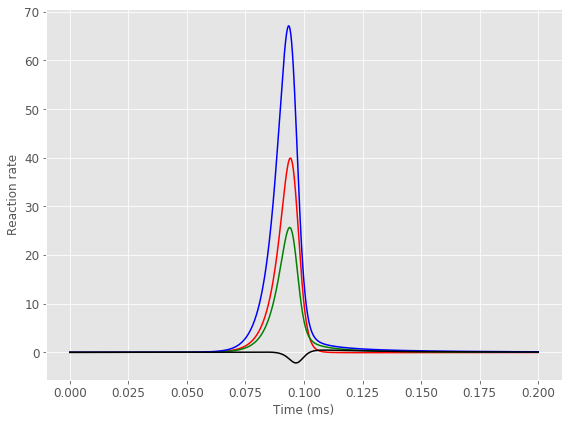

In [3]:
# plot reaction rates
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (8,6)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 

plt.figure()
plt.plot(time*1e3, RR[:,0], '-r')
plt.plot(time*1e3, RR[:,1], '-g')
plt.plot(time*1e3, RR[:,2], '-b')
plt.plot(time*1e3, RR[:,3], '-k')
plt.xlabel('Time (ms)')
plt.ylabel('Reaction rate');

### Step 2: Compute principal values and vectors

#### Scaling data matrix

In [4]:
def scaleData(nf, v):

    # compute mean
    v_mean = np.mean(v, axis=0)
    v_max = np.max(v, axis=0)

    # add for loop to scale the data: NORMALIZATION
    for i in range(nf):
        v[:, i] = (v[:, i] - v_mean[i])/v_max[i]
#         v[:, i] = (v[:, i])/v_max[i]

    return None

Xs = np.zeros((nt,nv)) # scaled data matrix
Xs = np.copy(X)

scaleData(nv,Xs)

#### Co-variance matrix

In [5]:
def covar(u, mom):
    # compute covariance matrix
    for j in range(nv):
        for i in range(nv):
            for n in range(nt):
                mom[i,j] = mom[i,j] + u[n,i] * u[n,j]
    return None

mom2 = np.zeros((nv, nv), dtype=float, order='F')
covar(Xs,mom2)
mom2[0].size

10

#### Co-kurtosis tensor (matricized)

In [6]:
def cokurt(u, tmp):
    # compute covariance matrix
    
    for l in range(nv):
        for k in range(nv):
            for j in range(nv):
                for i in range(nv):
                    for n in range(nt):
                        tmp[i,j,k,l] = tmp[i,j,k,l] + u[n,i] * u[n,j] * u[n,k] * u[n,l]
    return None


mom4_t = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
cokurt(Xx,mom4_t)

In [9]:
mom4 = np.reshape(mom4_t,(nv,nv*nv*nv),order='F')
mom4[0].size

1000

#### Principal values and vectors

In [11]:
# factorize co-variance matrix: SVD of the covariance matrix
U2, S2, V2 = np.linalg.svd(mom2)

# factorize co-kurtosis tensor
U4, S4, V4 = np.linalg.svd(mom4)

### Step 3: Data reduction

#### Compute principal comp